# CLASIFICACIÓN DE IMÁGENES SATELITALES SAOCOM PARA SU CATALOGADO WEB

<img src="Satelite_Saocom_INFO1.gif" style="height:400px"> 



<img src="Satelite_Saocom_INFO3.gif" style="height:500px"> 

# Problema: Imágenes "lindas" => OK

### Cataratas del Iguazú
<img src="Cataratas.jpg" style="height:400px" title="Cataratas" align="left"> 
<img src="Cataratas2.jpg" style="height:400px" title="Cataratas2" align="center"> 


### Volcán Popocatépetl México
<img src="VolcanMexico.jpg" style="height:470px" align="left"> 

### Riachuelo - La Plata - Buenos Aires
<img src="RiachueloLaPlata.jpg" style="height:390px" align="left"> 

# Problema: Imágenes "no tan lindas" => NOK


### Pérdida de líneas
<img src="NOKperdidaLineas2.jpg" style="height:450px" align="left"> 


### Sólo agua
<img src="NOK_Agua.jpg" style="height:400px" align="left"> 

### Ecualización de colores incorrecta
<img src="NOK_EcualizacionColores.jpg" style="height:400px" align="left"> 

### Tierra espejada en agua
<img src="NOK_espejada.jpg" style="height:400px" align="left"> 

### Interferencias
<img src="NOK_Interferencias.jpg" style="height:400px" align="left"> 

# Se deben seleccionar previamente las imágenes NOK para ocultarlas del catálogo, y dejar las OK en la página.

<img src="CatalogoSAOCOM.jpg" style="height:400px" align="left"> 

# Solución: 

# Crearemos una Convolutional Neural Network (CNN) con Keras y Tensorflow para reconocimiento de Imágenes.



<img src="meme_asombro.jpg" style="height:400px" align="left"> 

# Contamos con imágenes ya clasificadas como OK y otras como NOK, ubicadas en diferentes carpetas. 

### Se tenían más de 7mil imágenes, pero dejamos poco más de 2500, por la demora en cargarlas en memoria.

# ¡Vayamos al código!

# Importar Librerías

In [ ]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2 as cv

In [2]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


# Cargar set de Imágenes

In [3]:
dirname = os.path.join(os.getcwd(), 'images')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("Leyendo imagenes de: \n",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            #image = plt.imread(filepath)
            image = cv.imread(filepath, cv.IMREAD_COLOR) # Se fuerza a RRGB. Existían imágenes en RGB (3 dimensiones) y en CMYK (4 dimensiones)
            image = cv.resize(image,(64, 64))
            #cv.imshow("prueba",image)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                #print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant-1)
                cant=0
dircount.append(cant+1)

dircount = dircount[1:]
dircount[0]=dircount[0]+1

print('Cantidad de directorios leídos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('Total de imágenes en subdirs:', sum(dircount))

Leyendo imagenes de: 
 C:\Users\YIberra\Desktop\MachineLearning\TrabajoFinal\ClasificacionCatalogo\images\
Cantidad de directorios leídos: 2
Imagenes en cada directorio [2708, 63]
Total de imágenes en subdirs: 2771


## "images": lista de todas las imágenes

In [4]:
print(type(images)) # images: lista de todas las imágenes
print(len(images)) # total de imágenes en la lista

<class 'list'>
2771


## Cada imagen es un array de (64, 64, 3): 64 filas, 64 columnas y 3 dimensiones RGB, dentro de la lista "images".

In [5]:
print(type(image), "\n") # image: última imagen leída, cada imagen se accede como images[i] 

print(image.shape) # dimensiones del array de la última imagen leída

<class 'numpy.ndarray'> 

(64, 64, 3)


# Creamos las etiquetas (labels)
### Tenemos una lista con la cantidad de imágenes en la carpeta NOK (X) y OK (Y) => [X, Y]
### Labels será una lista de igual cantidad de elementos que el total de imágenes (X+Y)
### A los NOK los etiquetamos con el label 0 y a las imágenes OK con 1 (porque sólo hay dos carpetas).

In [6]:
# Ver de agregar acá la corrección de que no contabilice la imagen que no pudo hacer el resize.
labels=[]
indice=0
print(dircount)
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))
print(labels[0:10]) # primeras 10 etiquetas
print(labels[-10:]) # últimas 10 etiquetas

[2708, 63]
Cantidad etiquetas creadas:  2771
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [7]:
categories=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    categories.append(name[len(name)-1])
    indice=indice+1
    
print("\nLista de categories: ", categories)

0 NOK
1 OK

Lista de categories:  ['NOK', 'OK']


In [ ]:
# Con ésto vemos las dimensiones de las imágenes. Antes de convertir a RGB acá vimos algunas (64, 64, 4), en CMYK.
#for i in range(len(images)):
#    print(images[i].shape)

### Convertimos la lista de labels e imágenes a arrays con numpy

In [8]:
print("Lista labels:")
print(type(labels))
print(len(labels))
y = np.array(labels) # la lista labels se pasa a un array
print("Tipo después de la conversión:", type(y))
print(y.shape)
print("---------------------------\n")

print("Lista Images:")
print(type(images))
print(len(images))
X = np.array(images, dtype=np.float32) # convierto de lista  de imágenes a numpy de float32, los valores de cada ixel estaban en flotantes.
print("Tipo después de la conversión:", type(X))
print(X.shape) # primero está la cantidad de imágenes, cada una de 64 x 64 x 3
print("---------------------------\n")

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Lista labels:
<class 'list'>
2771
Tipo después de la conversión: <class 'numpy.ndarray'>
(2771,)
---------------------------

Lista Images:
<class 'list'>
2771
Tipo después de la conversión: <class 'numpy.ndarray'>
(2771, 64, 64, 3)
---------------------------

Total number of outputs :  2
Output classes :  [0 1]


# Creamos Sets de Entrenamiento y Test

### Dividiremos el set de datos en 80-20 para entrenamiento y para test. A su vez, el conjunto de entrenamiento también lo subdividiremos en otro 80-20 para Entrenamiento y Validación en cada iteración (EPOCH) de aprendizaje.

In [9]:
# X: Array de imágenes de 64x64x3
# y: array de labels de las imágenes
# train_X: conjunto de imágenes para entrenamiento del modelo
# train_Y: labels del conjunto de imágenes para entrenamiento del modelo
# test_X: conjunto de imágenes para test del modelo (para chequear muestras que no vio el algoritmo de entrenamiento)
# test_Y: labels del conjunto de imágenes para test del modelo

train_ratio = 0.80

print("Total de imágenes:", X.shape[0])

train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=1-train_ratio) # test_size=0.20

print("Type of train_X: ", type(train_X))


print('Training data shape : ', train_X.shape, train_Y.shape, "Percentage:", "{0:.2f}%".format((train_X.shape[0]*100)/X.shape[0]))
print('Testing data shape : ', test_X.shape, test_Y.shape, "Percentage:", "{0:.2f}%".format((test_X.shape[0]*100)/X.shape[0]))


Total de imágenes: 2771
Type of train_X:  <class 'numpy.ndarray'>
Training data shape :  (2216, 64, 64, 3) (2216,) Percentage: 79.97%
Testing data shape :  (555, 64, 64, 3) (555,) Percentage: 20.03%


# Preprocesamos las imágenes

In [10]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.
# VER QUÉ PASA SI COMENTAMOS ÉSTE BLOQUE:
# Da warnings y no se grafican bien:
# Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

### Ploteamos la primer imagen del conjunto de entrenamiento y la primer imagen del conjunto de test

Text(0.5, 1.0, 'Test first image label: 0')

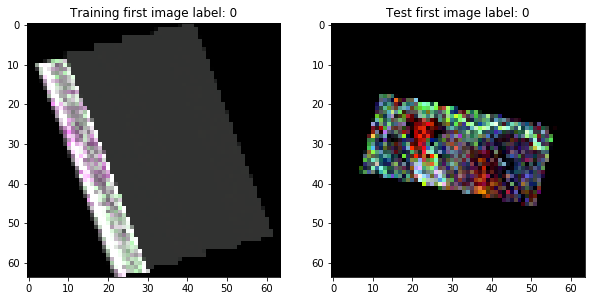

In [11]:
plt.figure(figsize=[10,10])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Training first image label: {}".format(train_Y[0])) # 0: NOK, 1: OK

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Test first image label: {}".format(test_Y[0])) # 0: NOK, 1: OK

## Hacemos el One-hot Encoding para la red
### En vez de tener:
- ### 0 para la categoría NOK y
- ### 1 para la categoría OK

### Vamos a tener un array con valor 0 o 1 según corresponda en [NOK, OK], es decir:
- ### [1., 0.] para la categoría NOK
- ### [0., 1.] para la categoría OK

In [12]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print(type(train_Y_one_hot[0]))
print('After conversion to one-hot:', train_Y_one_hot[0]) # [0. 1.] => NOK:0, OK:1, [1. 0.] => NOK:1, OK:0

Original label: 0
<class 'numpy.ndarray'>
After conversion to one-hot: [1. 0.]


# Creamos el Set de Entrenamiento y Validación

### Al conjunto de entrenamiento inicial (80%) también lo subdividiremos en otro 80-20 para Entrenamiento y Validación en cada iteración (EPOCH) de aprendizaje.

In [13]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X_original = train_X.shape[0]
print("Cantidad de imágenes en el conjunto de entrenamiento inicial: ", train_X_original)
train_X,val_X,train_Y,val_Y = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

Cantidad de imágenes en el conjunto de entrenamiento inicial:  2216


In [14]:
print(train_X.shape,val_X.shape,train_Y.shape,val_Y.shape)

print('Training data shape : ', train_X.shape, train_Y.shape, "Percentage:", "{0:.2f}%".format((train_X.shape[0]*100)/train_X_original))
print('Validation data shape : ', val_X.shape, val_Y.shape, "Percentage:", "{0:.2f}%".format((val_X.shape[0]*100)/train_X_original))

(1772, 64, 64, 3) (444, 64, 64, 3) (1772, 2) (444, 2)
Training data shape :  (1772, 64, 64, 3) (1772, 2) Percentage: 79.96%
Validation data shape :  (444, 64, 64, 3) (444, 2) Percentage: 20.04%


### En resumen tenemos para cada conjunto: Train, Val, Test:

In [15]:
# En resumen tenemos:
print('Training data shape : ', train_X.shape, train_Y.shape, "Percentage:", "{0:.2f}%".format((train_X.shape[0]*100)/X.shape[0]))
print('Validation data shape : ', val_X.shape, val_Y.shape, "Percentage:", "{0:.2f}%".format((val_X.shape[0]*100)/X.shape[0]))
print('Testing data shape : ', test_X.shape, test_Y.shape, "Percentage:", "{0:.2f}%".format((test_X.shape[0]*100)/X.shape[0]))


Training data shape :  (1772, 64, 64, 3) (1772, 2) Percentage: 63.95%
Validation data shape :  (444, 64, 64, 3) (444, 2) Percentage: 16.02%
Testing data shape :  (555, 64, 64, 3) (555,) Percentage: 20.03%


# Creamos el modelo de CNN (Convolutional Neural Network)

- Declaramos 3 «constantes»:
    - El valor inicial del learning rate INIT_LR
    - cantidad de epochs  y
    - tamaño batch de imágenes a procesar batch_size  (cargan en memoria).
- Crearemos una primer capa de neuronas  «Convolucional de 2 Dimensiones» Conv2D() , donde entrarán nuestras imágenes de 64x64x3.
- Aplicaremos 32 filtros (kernel) de tamaño 3×3 que detectan ciertas características de la imagen (ejemplo: lineas verticales).
- Utilizaremos La función LeakyReLU como activación de las neuronas.
- Haremos un MaxPooling (de 2×2) que reduce la imagen que entra de 64×64 a la mitad,(32×32) manteniendo las características «únicas» que detectó cada kernel.
- Para evitar el overfitting, añadimos una técnica llamada Dropout.
- «Aplanamos» Flatten()  los 32 filtros y creamos una capa de 32 neuronas «tradicionales» Dense()
- Y finalizamos la capa de salida con 2 neuronas con activación Softmax, para que se corresponda con el «hot encoding» que hicimos antes.
- Luego compilamos nuestra red catalog_model.compile()  y le asignamos un optimizador (en este caso de llama Adagrad).

In [16]:
# Declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 6 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [17]:
catalog_model = Sequential()
catalog_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(64,64,3)))
catalog_model.add(LeakyReLU(alpha=0.1))
catalog_model.add(MaxPooling2D((2, 2),padding='same'))
catalog_model.add(Dropout(0.5))

catalog_model.add(Flatten())
catalog_model.add(Dense(32, activation='linear'))
catalog_model.add(LeakyReLU(alpha=0.1))
catalog_model.add(Dropout(0.5))
catalog_model.add(Dense(nClasses, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
catalog_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1048608   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)               

In [19]:
catalog_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes
### Se utilizan los datos de entrenamiento y validación

In [20]:
# Éste paso puede tomar varios minutos, dependiendo de la máquina, cpu y memoria ram libre
catalog_train = catalog_model.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(val_X, val_Y))

Instructions for updating:
Use tf.cast instead.
Train on 1772 samples, validate on 444 samples
Epoch 1/6
1772/1772 [==============================] - 15s 8ms/step - loss: 0.1929 - accuracy: 0.9577 - val_loss: 0.1433 - val_accuracy: 0.9775
Epoch 2/6
1772/1772 [==============================] - 10s 6ms/step - loss: 0.1230 - accuracy: 0.9808 - val_loss: 0.1336 - val_accuracy: 0.9775
Epoch 3/6
1772/1772 [==============================] - 10s 6ms/step - loss: 0.1251 - accuracy: 0.9808 - val_loss: 0.1198 - val_accuracy: 0.9775
Epoch 4/6
1772/1772 [==============================] - 7s 4ms/step - loss: 0.1062 - accuracy: 0.9808 - val_loss: 0.1180 - val_accuracy: 0.9775
Epoch 5/6
1772/1772 [==============================] - 6s 3ms/step - loss: 0.1083 - accuracy: 0.9808 - val_loss: 0.1141 - val_accuracy: 0.9775
Epoch 6/6
1772/1772 [==============================] - 6s 3ms/step - loss: 0.0996 - accuracy: 0.9808 - val_loss: 0.1091 - val_accuracy: 0.9775


### Vemos que tras 6 iteraciones completas al set de entrenamiento, logramos un valor de precisión del 98% y en el set de validación alcanza un 97%.

In [21]:
# Guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
catalog_model.save("catalog_mnist.h5py")

# Evaluamos la red
### Verificamos el modelo con el set de imágenes que reservamos para test

In [22]:
test_eval = catalog_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print(catalog_model.metrics_names)
print('Test accuracy:', test_eval[1])
print('Test loss:', test_eval[0])

555/555 [==============================] - 1s 1ms/step
['loss', 'accuracy']
Test accuracy: 0.9657657742500305
Test loss: 0.14685449314278526


### En el conjunto de Testing vemos que alcanza una precisión del 96% reconociendo las imágenes OK y NOK.

In [23]:
catalog_train.history #modelo entrenado

{'val_loss': [0.14325529682609411,
  0.13363451235466176,
  0.1198070015389103,
  0.11795360009345385,
  0.11412389989237527,
  0.10906042868422496],
 'val_accuracy': [0.977477490901947,
  0.977477490901947,
  0.977477490901947,
  0.977477490901947,
  0.977477490901947,
  0.977477490901947],
 'loss': [0.19294896253445618,
  0.12302896232421996,
  0.12506306443876392,
  0.10616091731305047,
  0.10827290941172744,
  0.09964473424458342],
 'accuracy': [0.9576749,
  0.98081267,
  0.98081267,
  0.98081267,
  0.98081267,
  0.98081267]}

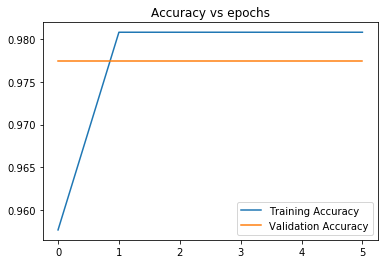

In [24]:
plt.figure()
plt.title("Accuracy vs epochs")
plt.plot(catalog_train.history['accuracy'] )
plt.plot(catalog_train.history['val_accuracy'] )
plt.legend(['Training Accuracy', 'Validation Accuracy'])

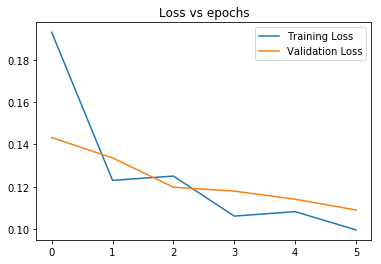

In [25]:
plt.figure()
plt.title("Loss vs epochs")
plt.plot( catalog_train.history['loss'] )
plt.plot( catalog_train.history['val_loss'] )
plt.legend(['Training Loss', 'Validation Loss'])

# Usemos este modelo para hacer predicciones

In [26]:
predicted_classes2 = catalog_model.predict(test_X)

In [27]:
predicted_classes=[]
for predicted_category in predicted_classes2:
    predicted_classes.append(predicted_category.tolist().index(max(predicted_category)))
predicted_classes=np.array(predicted_classes)

Found 536 correct labels


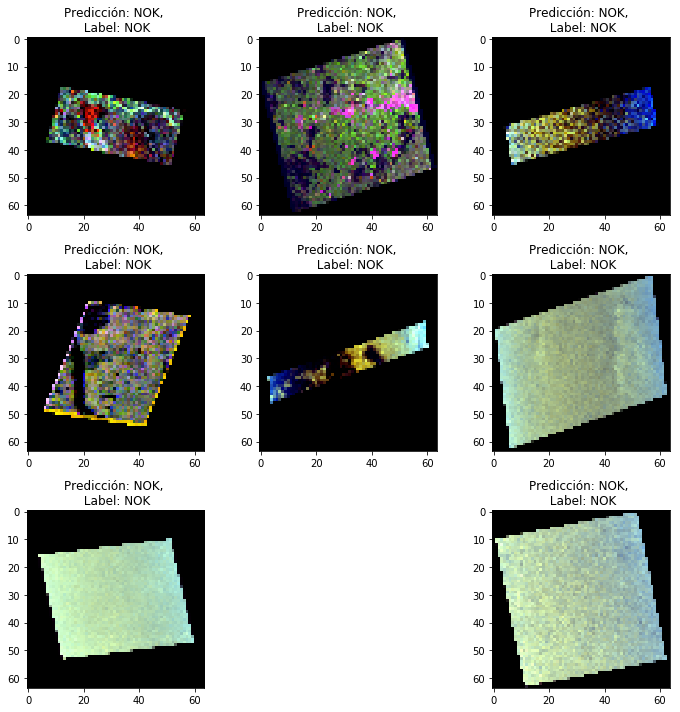

In [28]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
plt.figure(figsize=(10,10))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(64,64,3), cmap='gray', interpolation='none')
    plt.title("Predicción: {}, \n Label: {}".format(categories[predicted_classes[correct]],
                                                    categories[test_Y[correct]]))

    plt.tight_layout()

Found 19 incorrect labels


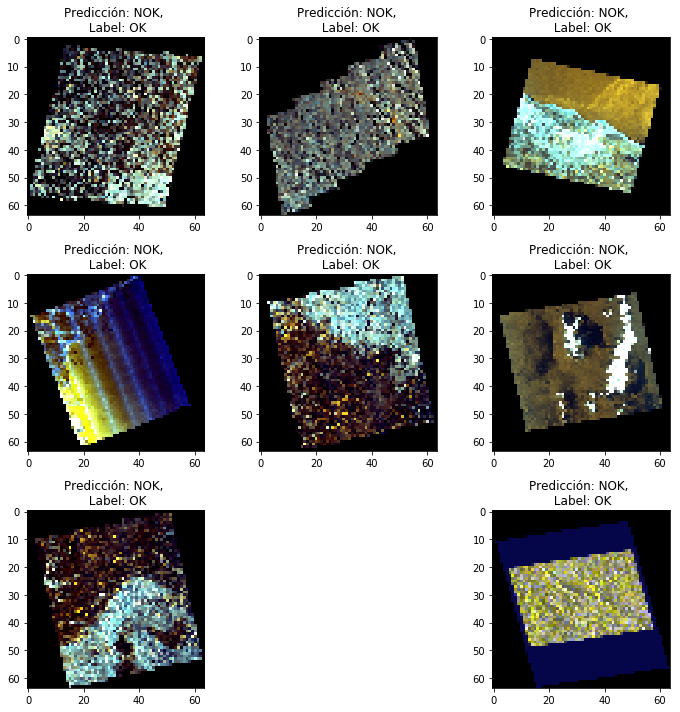

In [29]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
plt.figure(figsize=(10,10))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(64,64,3), cmap='gray', interpolation='none')
    plt.title("Predicción: {}, \n Label: {}".format(categories[predicted_classes[incorrect]],
                                                    categories[test_Y[incorrect]]))
    plt.tight_layout()

In [30]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98       536
     Class 1       0.00      0.00      0.00        19

   micro avg       0.97      0.97      0.97       555
   macro avg       0.48      0.50      0.49       555
weighted avg       0.93      0.97      0.95       555



C:\Users\YIberra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
